# Tutorial: Depth-from-Stereo Estimation with Foundation Stereo

## Introduction

This tutorial demonstrates how to compute metric depth maps from Aria Gen2 stereo cameras using stereo rectification and the Foundation Stereo neural network. You will learn the complete pipeline from loading VRS data to visualizing 3D depth in Rerun.

**What you'll learn:**
- Load stereo camera data from Aria Gen2 VRS files
- Perform stereo rectification on fisheye images to align epipolar lines
- Use Foundation Stereo for zero-shot disparity estimation
- Convert disparity to metric depth using camera calibration
- Visualize depth as interactive 3D point clouds with Rerun

**Key Concepts:**
- **Stereo Rectification**: Process of transforming stereo images so epipolar lines are horizontal, simplifying stereo matching from 2D to 1D search
- **Disparity**: Horizontal pixel displacement between corresponding points in left/right images
- **Depth from Disparity**: `Z = (baseline × focal_length) / disparity`
- **Foundation Stereo**: Zero-shot stereo matching neural network that works across diverse scenes without fine-tuning

**Prerequisites:**
- CUDA-capable GPU (2-4GB VRAM)
- Familiarity with Project Aria Tools (see Tutorial 1: VrsDataProvider Basics)
- Understanding of camera calibration concepts (see Tutorial 2: Device Calibration)
- Basic understanding of stereo geometry

### ⚠️ Important Notes
- **Google Colab Users:**  
  If you encounter a `ModuleNotFoundError: No module named 'rerun'` error after installing `rerun-sdk`, Colab may not recognize the new package until the runtime is restarted.  
  **Fix:** Go to **Runtime → Restart session and run all**.

- **Visualization Issue:**  
  If a Rerun visualization window does not appear, this may be due to a known caching issue. Simply re-run the visualization cell to resolve it.

## Setup Environment (Google Colab)

If running on Google Colab, install `projectaria-tools`, Foundation Stereo dependencies, and download sample data.

In [1]:
import sys
import os

google_colab_env = 'google.colab' in str(get_ipython())

if google_colab_env:
    print("Running from Google Colab, installing dependencies and downloading sample data")

    # Install dependencies
    !pip install projectaria-tools['all']==2.0.0
    !pip install omegaconf

    # Clone Foundation Stereo
    !git clone https://github.com/NVlabs/FoundationStereo.git

    # Download checkpoint (users need to obtain from NVIDIA)
    # See: https://github.com/NVlabs/FoundationStereo for checkpoint download instructions
    print("NOTE: You need to download Foundation Stereo checkpoints from NVIDIA.")
    print("Visit https://github.com/NVlabs/FoundationStereo for instructions.")

    # Download sample VRS
    vrs_sample_path = "./vrs_sample_data"
    vrs_url = "https://www.projectaria.com/async/sample/download/?bucket=core&filename=aria_gen2_sample_data_1.vrs"
    vrs_filename = "aria_gen2_sample_data_1.vrs"
    vrs_file_path = os.path.join(vrs_sample_path, vrs_filename)

    command_list = [
        f"mkdir -p {vrs_sample_path}",
        f'curl -o {vrs_file_path} -C - -O -L "{vrs_url}"'
    ]

    print(f"Downloading VRS sample data to {vrs_file_path}...")
    for command in command_list:
        !$command

    print(f"Download complete! VRS file saved to: {vrs_file_path}")

    FOUNDATION_STEREO_CKPT = "./FoundationStereo/pretrained_models/23-51-11/model_best_bp2.pth"

    # Running this command to trigger early failure of importing ReRun
    # Should be resolved by restarting the Colab session
    import rerun as rr
else:
    # Local environment - update these paths
    vrs_file_path = "/nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs"
    foundation_stereo_ckpt = "./aria2mano/FoundationStereo/pretrained_models/23-51-11/model_best_bp2.pth"
    print("Please update vrs_file_path to point to an Aria-Gen2 VRS file on your system")

Please update vrs_file_path to point to an Aria-Gen2 VRS file on your system


## 1. Environment Setup

First, we'll import all required libraries and verify GPU availability.

In [2]:
# Standard library imports
import os
import sys
import time
from pathlib import Path

# Numerical and visualization imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch for Foundation Stereo
import torch

# Project Aria Tools imports
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sophus import SE3, SO3
from projectaria_tools.core.image import InterpolationMethod

# Rerun for 3D visualization
import rerun as rr

print("All imports successful")

All imports successful


In [3]:
# Foundation Stereo Setup
from pathlib import Path

# For Google Colab: clone repository
if 'google.colab' in str(get_ipython()):
    if not Path('./FoundationStereo').exists():
        !git clone https://github.com/NVlabs/FoundationStereo.git
    FOUNDATION_STEREO_PATH = './FoundationStereo'
else:
    # Local environment: check common locations or use environment variable
    search_paths = [
        os.environ.get('FOUNDATION_STEREO_PATH'),
        Path.cwd() / 'FoundationStereo',
        Path.home() / 'FoundationStereo',
        Path.home() / 'projects' / 'FoundationStereo',
        Path.home() / 'projects' / 'nebula_foundation_stereo_notebook' / 'FoundationStereo',
    ]

    FOUNDATION_STEREO_PATH = None
    for path in search_paths:
        if path and Path(path).exists() and (Path(path) / 'core').exists():
            FOUNDATION_STEREO_PATH = str(path)
            break

    if FOUNDATION_STEREO_PATH is None:
        raise FileNotFoundError(
            "FoundationStereo not found. Please either:\n"
            "  1. git clone https://github.com/NVlabs/FoundationStereo.git\n"
            "  2. Set FOUNDATION_STEREO_PATH environment variable\n"
        )

# Add to Python path
sys.path.insert(0, FOUNDATION_STEREO_PATH)

# Import Foundation Stereo components
from omegaconf import OmegaConf
from core.foundation_stereo import FoundationStereo
from core.utils.utils import InputPadder

# Stereo utilities from projectaria_tools
from stereo_utils import (
    create_scanline_rectified_cameras,
    fisheye_to_linear_calib,
    rectify_stereo_pair,
    compute_stereo_baseline,
    disparity_to_depth,
    get_rectified_camera_transform,
)

print(f"Foundation Stereo loaded from: {FOUNDATION_STEREO_PATH}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Foundation Stereo loaded from: /home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo


In [4]:
# Check GPU availability
print("System Information:")
print(f"  PyTorch version: {torch.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  CUDA version: {torch.version.cuda}")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("\nGPU ready for Foundation Stereo inference")
else:
    print("\nWARNING: No GPU detected. Foundation Stereo requires CUDA.")

System Information:
  PyTorch version: 2.4.1+cu121
  CUDA available: True
  CUDA version: 12.1
  GPU: NVIDIA RTX A4000
  GPU memory: 16.9 GB

GPU ready for Foundation Stereo inference


## 2. Configure Paths and Parameters

In [5]:
# Configuration
# VRS file path - update for your local environment
VRS_FILE_PATH = vrs_file_path if 'vrs_file_path' in dir() else "path/to/your/recording.vrs"

# Foundation Stereo checkpoint (relative to FOUNDATION_STEREO_PATH)
FOUNDATION_STEREO_CKPT = os.path.join(FOUNDATION_STEREO_PATH, "pretrained_models/23-51-11/model_best_bp2-001.pth")

# Frame to process
FRAME_INDEX = 100

# Rectification parameters
OUTPUT_WIDTH = 512
OUTPUT_HEIGHT = 512
FOCAL_SCALE = 1.25

# Foundation Stereo parameters
VALID_ITERS = 32

# Depth parameters
MIN_DISPARITY = 1.0
MAX_DEPTH = 20.0

print(f"VRS file: {VRS_FILE_PATH}")
print(f"Checkpoint: {FOUNDATION_STEREO_CKPT}")
print(f"Output: {OUTPUT_WIDTH}x{OUTPUT_HEIGHT}")

VRS file: /nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs
Checkpoint: /home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo/pretrained_models/23-51-11/model_best_bp2-001.pth
Output: 512x512


## 3. Load VRS Data and Extract Calibration

In [6]:
# Load VRS file
print(f"Loading VRS file: {VRS_FILE_PATH}")
vrs_data_provider = data_provider.create_vrs_data_provider(VRS_FILE_PATH)
assert vrs_data_provider is not None, f"Failed to load VRS file"

device_calib = vrs_data_provider.get_device_calibration()

# Identify stereo camera streams
left_stream_id = vrs_data_provider.get_stream_id_from_label("slam-front-left")
right_stream_id = vrs_data_provider.get_stream_id_from_label("slam-front-right")

assert left_stream_id is not None, "Could not find slam-front-left stream"
assert right_stream_id is not None, "Could not find slam-front-right stream"

left_num_frames = vrs_data_provider.get_num_data(left_stream_id)
right_num_frames = vrs_data_provider.get_num_data(right_stream_id)

print(f"VRS file loaded")
print(f"  Left: {left_stream_id}, {left_num_frames} frames")
print(f"  Right: {right_stream_id}, {right_num_frames} frames")

Loading VRS file: /nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs
VRS file loaded
  Left: 1201-1, 746 frames
  Right: 1201-2, 746 frames


[ProgressLogger][INFO]: 2026-02-02 19:27:14: Opening /nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et-left activated
[VrsDataProvider][INFO]: streamId 211-2/camera-et-right activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 246-1/temperature activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 248-1/ppg activated
[VrsDataProvider][INFO]: streamId 281-1/gps-app activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][INFO]: Utc stream found: 285-1
[VrsDataProvider][INFO]: streamId 371-1/handtracking activated
[VrsData

In [7]:
# Get camera calibrations
left_calib = device_calib.get_camera_calib("slam-front-left")
right_calib = device_calib.get_camera_calib("slam-front-right")

T_left_cam_device = left_calib.get_transform_device_camera().inverse()
T_right_cam_device = right_calib.get_transform_device_camera().inverse()

baseline = compute_stereo_baseline(T_left_cam_device, T_right_cam_device)

print("Camera Calibration:")
print(f"  Left: {left_calib.get_model_name()}, {left_calib.get_image_size()}")
print(f"  Right: {right_calib.get_model_name()}, {right_calib.get_image_size()}")
print(f"  Baseline: {baseline*1000:.1f} mm")

Camera Calibration:
  Left: CameraModelType.FISHEYE624, [512 512]
  Right: CameraModelType.FISHEYE624, [512 512]
  Baseline: 134.1 mm


## 4. Load Stereo Frame Pair

In [8]:
# Load images
left_data, left_record = vrs_data_provider.get_image_data_by_index(left_stream_id, FRAME_INDEX)
right_data, right_record = vrs_data_provider.get_image_data_by_index(right_stream_id, FRAME_INDEX)

left_image = left_data.to_numpy_array()
right_image = right_data.to_numpy_array()
timestamp_ns = left_record.capture_timestamp_ns

print(f"Frame {FRAME_INDEX} loaded")
print(f"  Shape: {left_image.shape}")
print(f"  Timestamp: {timestamp_ns} ns")

Frame 100 loaded
  Shape: (512, 512)
  Timestamp: 849932866689483 ns


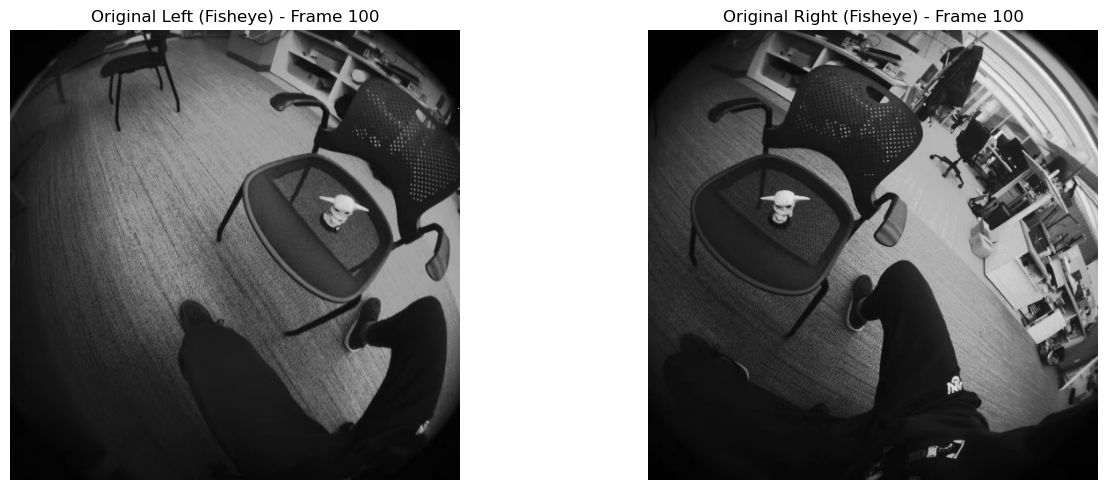

In [9]:
# Visualize original fisheye images
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(left_image, cmap='gray')
axes[0].set_title(f'Original Left (Fisheye) - Frame {FRAME_INDEX}')
axes[0].axis('off')
axes[1].imshow(right_image, cmap='gray')
axes[1].set_title(f'Original Right (Fisheye) - Frame {FRAME_INDEX}')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 5. Stereo Rectification

**Understanding Stereo Rectification:**

Stereo rectification transforms the stereo pair to satisfy:
1. **Horizontal epipolar lines** - corresponding points lie on the same row
2. **No lens distortion** - fisheye distortion is removed  
3. **Common image plane** - both cameras project onto aligned planes

This simplifies stereo matching from 2D to 1D search (along each row).

In [10]:
# Create linear (pinhole) camera calibrations
print("Creating rectified camera models...")

left_linear = fisheye_to_linear_calib(
    left_calib, focal_scale=FOCAL_SCALE,
    output_width=OUTPUT_WIDTH, output_height=OUTPUT_HEIGHT
)
right_linear = fisheye_to_linear_calib(
    right_calib, focal_scale=FOCAL_SCALE,
    output_width=OUTPUT_WIDTH, output_height=OUTPUT_HEIGHT
)

print(f"Linear models created: {OUTPUT_WIDTH}x{OUTPUT_HEIGHT}")
print(f"  Focal length: {left_linear.get_projection_params()[0]:.1f} px")

Creating rectified camera models...
Linear models created: 512x512
  Focal length: 308.0 px


In [11]:
# Compute rectification rotations
Rl_n, Rr_n = create_scanline_rectified_cameras(T_left_cam_device, T_right_cam_device)
print("Rectification rotations computed")

Rectification rotations computed


In [12]:
# Apply rectification
start_time = time.time()
left_rectified, right_rectified = rectify_stereo_pair(
    left_image, right_image, left_calib, right_calib,
    left_linear, right_linear, Rl_n, Rr_n,
    interpolation=InterpolationMethod.BILINEAR
)
rectify_time = (time.time() - start_time) * 1000

print(f"Rectification complete in {rectify_time:.1f} ms")
print(f"  Output shape: {left_rectified.shape}")

Rectification complete in 11.5 ms
  Output shape: (512, 512)


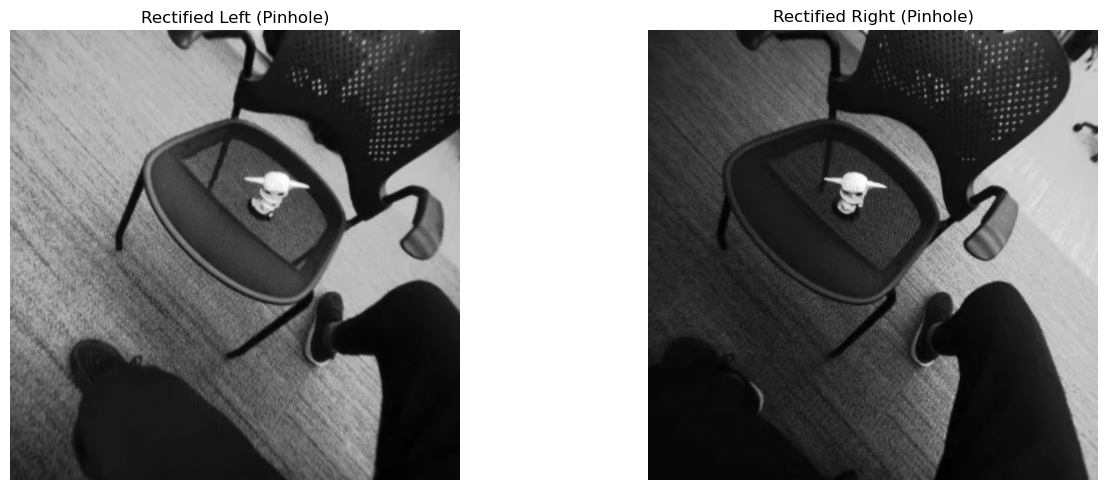

In [13]:
# Visualize rectified images
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(left_rectified, cmap='gray')
axes[0].set_title('Rectified Left (Pinhole)')
axes[0].axis('off')
axes[1].imshow(right_rectified, cmap='gray')
axes[1].set_title('Rectified Right (Pinhole)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

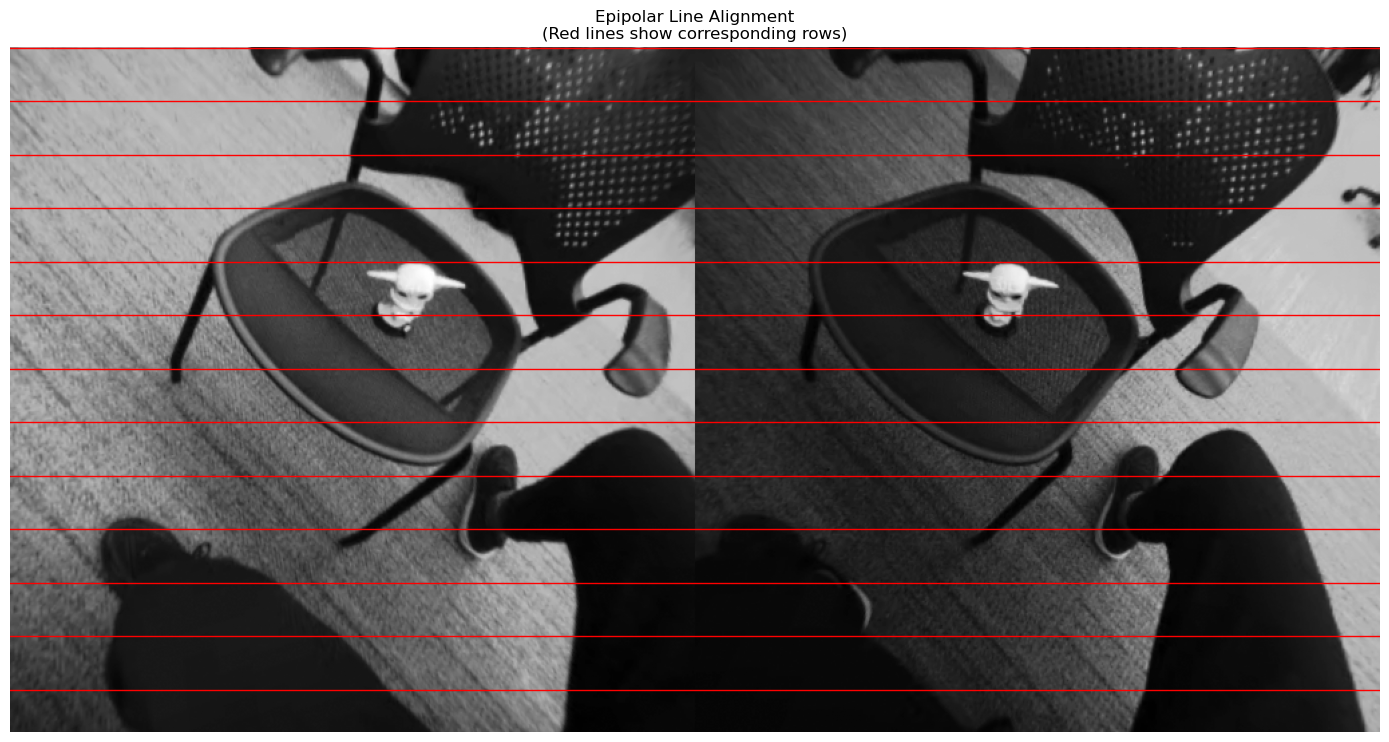

Rectification verified: epipolar lines are horizontal


In [14]:
# Verify epipolar alignment
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
stacked = np.hstack([left_rectified, right_rectified])
ax.imshow(stacked, cmap='gray')
for y in range(0, OUTPUT_HEIGHT, 40):
    ax.axhline(y, color='red', linewidth=1.0, alpha=1.0)
ax.set_title('Epipolar Line Alignment\n(Red lines show corresponding rows)')
ax.axis('off')
plt.tight_layout()
plt.show()
print("Rectification verified: epipolar lines are horizontal")

## 6. Foundation Stereo Inference

Foundation Stereo is a zero-shot stereo matching neural network that computes disparity without requiring fine-tuning for new scenes.

In [15]:
# Load Foundation Stereo model
print(f"Loading Foundation Stereo...")
cfg_path = os.path.join(os.path.dirname(FOUNDATION_STEREO_CKPT), 'cfg.yaml')
cfg = OmegaConf.load(cfg_path)
if 'vit_size' not in cfg:
    cfg['vit_size'] = 'vitl'
cfg.valid_iters = VALID_ITERS

model = FoundationStereo(cfg)
ckpt = torch.load(FOUNDATION_STEREO_CKPT, map_location='cpu', weights_only=False)
model.load_state_dict(ckpt['model'])
model = model.cuda().eval()

print(f"Model loaded (epoch {ckpt['epoch']})")
print(f"  ViT: {cfg.vit_size}, Iterations: {cfg.valid_iters}")

Loading Foundation Stereo...


Using cache found in /home_shared/grail_isaac/.cache/torch/hub/facebookresearch_dinov2_main
/home_shared/grail_isaac/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home_shared/grail_isaac/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home_shared/grail_isaac/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
using MLP layer as FFN


Model loaded (epoch 40)
  ViT: vitl, Iterations: 32


In [16]:
# Prepare input tensors
if len(left_rectified.shape) == 2:
    left_rgb = np.stack([left_rectified] * 3, axis=-1)
    right_rgb = np.stack([right_rectified] * 3, axis=-1)
else:
    left_rgb = left_rectified
    right_rgb = right_rectified

left_tensor = torch.from_numpy(left_rgb).float().cuda().permute(2, 0, 1).unsqueeze(0)
right_tensor = torch.from_numpy(right_rgb).float().cuda().permute(2, 0, 1).unsqueeze(0)

padder = InputPadder(left_tensor.shape, divis_by=32, force_square=False)
left_padded, right_padded = padder.pad(left_tensor, right_tensor)

print(f"Input shape: {left_padded.shape}")

Input shape: torch.Size([1, 3, 512, 512])


In [17]:
# Run inference
print("Running Foundation Stereo...")
start_time = time.time()

with torch.cuda.amp.autocast(True):
    with torch.no_grad():
        disparity = model.forward(left_padded, right_padded, iters=cfg.valid_iters, test_mode=True)

inference_time = (time.time() - start_time) * 1000
disparity = padder.unpad(disparity.float())
disparity_map = disparity.cpu().numpy().squeeze()

print(f"Inference complete in {inference_time:.1f} ms")
print(f"  Disparity range: [{disparity_map.min():.2f}, {disparity_map.max():.2f}] px")

Running Foundation Stereo...


/tmp/ipykernel_2851911/3521178339.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo/core/foundation_stereo.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo/core/submodule.py:390: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo/core/geometry.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` inst

Inference complete in 1128.9 ms
  Disparity range: [0.04, 165.32] px


/home_shared/grail_isaac/aria2mano/projectaria_gen2_depth_from_stereo/FoundationStereo/core/foundation_stereo.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


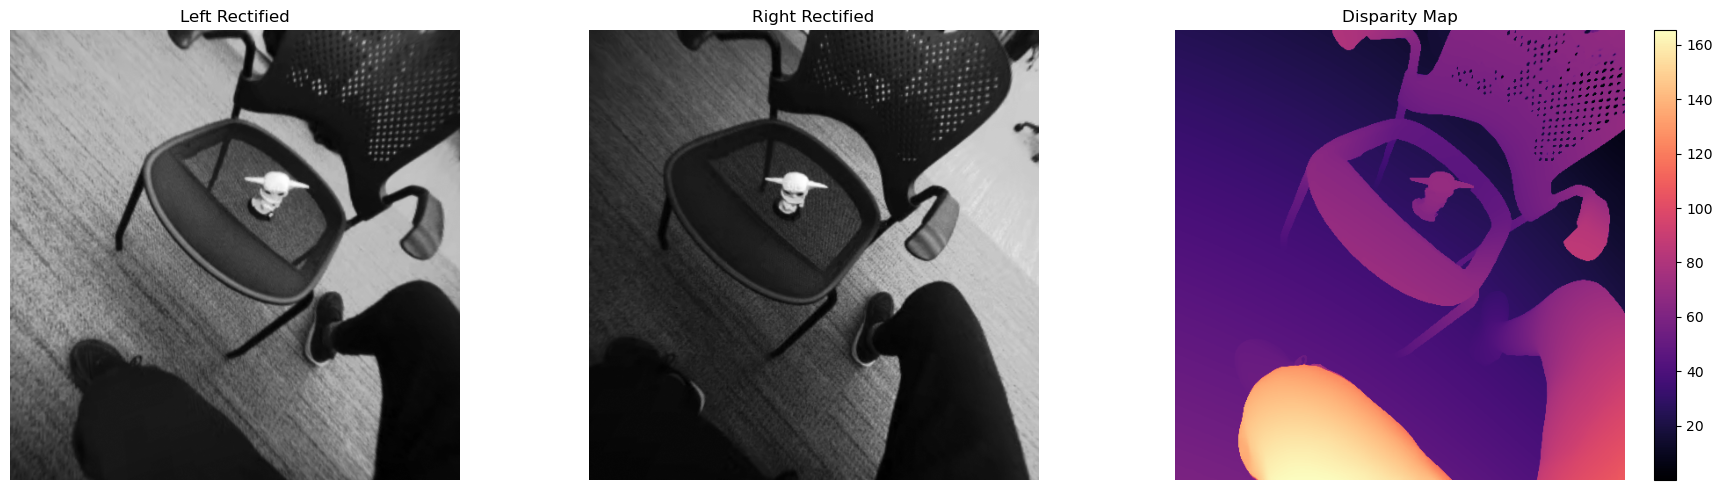

In [18]:
# Visualize disparity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(left_rectified, cmap='gray')
axes[0].set_title('Left Rectified')
axes[0].axis('off')
axes[1].imshow(right_rectified, cmap='gray')
axes[1].set_title('Right Rectified')
axes[1].axis('off')
disp_vis = axes[2].imshow(disparity_map, cmap='magma')
axes[2].set_title('Disparity Map')
axes[2].axis('off')
plt.colorbar(disp_vis, ax=axes[2], fraction=0.046)
plt.tight_layout()
plt.show()

## 7. Convert Disparity to Depth

We convert disparity to metric depth using: **`depth = (baseline × focal_length) / disparity`**

In [19]:
# Get focal length
focal_length = left_linear.get_projection_params()[0]
print(f"Baseline: {baseline:.4f} m ({baseline*1000:.1f} mm)")
print(f"Focal length: {focal_length:.2f} px")
print(f"Formula: depth = ({baseline:.4f} × {focal_length:.2f}) / disparity")

Baseline: 0.1341 m (134.1 mm)
Focal length: 307.98 px
Formula: depth = (0.1341 × 307.98) / disparity


In [20]:
# Convert to depth
depth_map = disparity_to_depth(
    disparity_map, baseline=baseline, focal_length=focal_length,
    min_disparity=MIN_DISPARITY, max_depth=MAX_DEPTH
)

valid_depth = depth_map[depth_map > 0]
print(f"\nDepth map computed")
print(f"  Valid pixels: {len(valid_depth)/depth_map.size*100:.1f}%")
print(f"  Depth range: [{valid_depth.min():.2f}, {valid_depth.max():.2f}] m")
print(f"  Mean depth: {valid_depth.mean():.2f} m")


Depth map computed
  Valid pixels: 100.0%
  Depth range: [0.25, 20.00] m
  Mean depth: 1.05 m


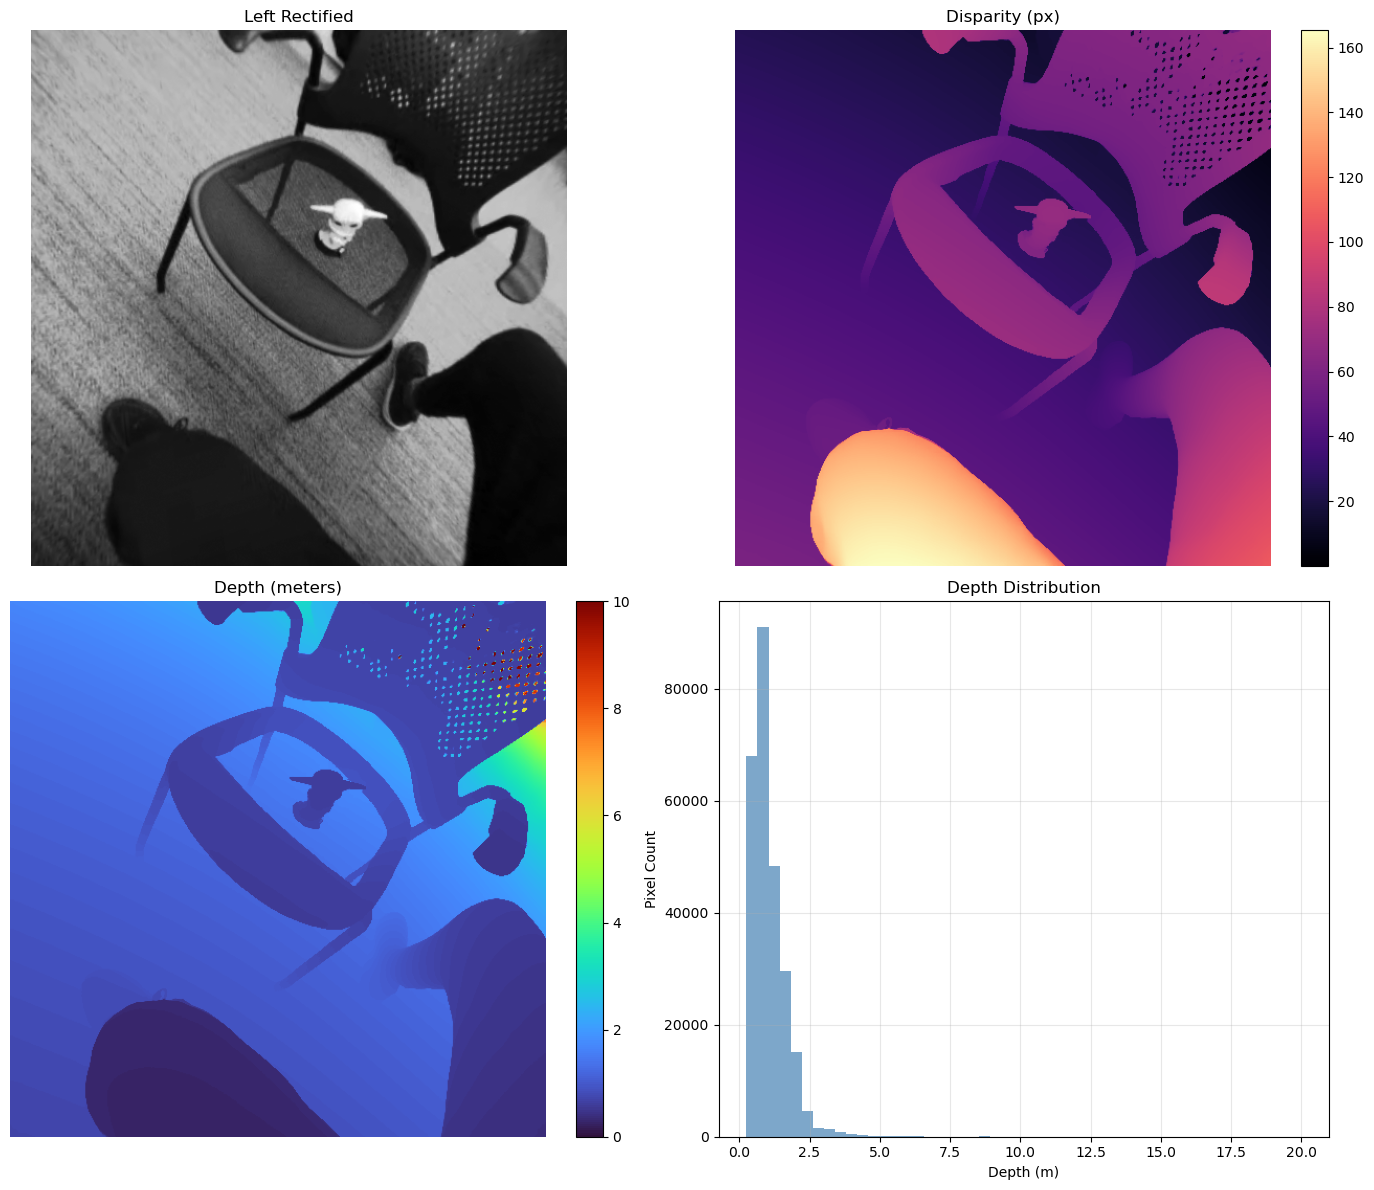

In [21]:
# Visualize depth
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes[0,0].imshow(left_rectified, cmap='gray')
axes[0,0].set_title('Left Rectified')
axes[0,0].axis('off')
disp_vis = axes[0,1].imshow(disparity_map, cmap='magma')
axes[0,1].set_title('Disparity (px)')
axes[0,1].axis('off')
plt.colorbar(disp_vis, ax=axes[0,1], fraction=0.046)
depth_vis = axes[1,0].imshow(depth_map, cmap='turbo', vmin=0, vmax=10)
axes[1,0].set_title('Depth (meters)')
axes[1,0].axis('off')
plt.colorbar(depth_vis, ax=axes[1,0], fraction=0.046)
axes[1,1].hist(valid_depth, bins=50, color='steelblue', alpha=0.7)
axes[1,1].set_xlabel('Depth (m)')
axes[1,1].set_ylabel('Pixel Count')
axes[1,1].set_title('Depth Distribution')
axes[1,1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 3D Visualization with Rerun

Visualize the depth map as a 3D point cloud using Rerun.

In [32]:
# ================================
# NOTEBOOK BOOTSTRAP (DO NOT MOVE)
# ================================
import sys
from pathlib import Path

# Find project root by locating src/aria_loader.py
HERE = Path().resolve()
PROJECT_ROOT = None

for p in [HERE] + list(HERE.parents):
    if (p / "src" / "aria_loader.py").exists():
        PROJECT_ROOT = p
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not find src/aria_loader.py — check repo layout")

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✔ Project root added to sys.path:", PROJECT_ROOT)

✔ Project root added to sys.path: /home_shared/grail_isaac/aria2mano


In [33]:
# Initialize Rerun
rr.init("aria_stereo_depth_tutorial")
rr.set_time_nanos("device_time", timestamp_ns)
print("Rerun initialized")

Rerun initialized


In [34]:
# ===============================
# Initialize AriaDataProvider (ONE CELL)
# ===============================
from pathlib import Path

from src.utils.aria_data_provider import AriaDataProvider

ARIA_PATH = Path("/nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4")

aria_provider = AriaDataProvider(ARIA_PATH)

print("✔ AriaDataProvider initialized")


pose = aria_provider.get_mps_interpolated_closed_loop_pose(
    timestamp_ns,
    time_domain=TimeDomain.DEVICE_TIME,
)
if pose is None:
    raise RuntimeError("No MPS pose available at this timestamp")

print(dir(pose))

T_world_device = pose.transform_world_device

✔ AriaDataProvider initialized
Loaded #closed loop trajectory poses records: 23900
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_conduit_v1_', 'angular_velocity_device', 'device_linear_velocity_device', 'graph_uid', 'gravity_world', 'quality_score', 'tracking_timestamp', 'transform_world_device', 'utc_timestamp']


[ProgressLogger][INFO]: 2026-02-02 19:31:49: Opening /nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4/video.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et-left activated
[VrsDataProvider][INFO]: streamId 211-2/camera-et-right activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 246-1/temperature activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 248-1/ppg activated
[VrsDataProvider][INFO]: streamId 281-1/gps-app activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][INFO]: Utc stream found: 285-1
[VrsDataProvider][INFO]: streamId 371-1/handtracking activated
[VrsData

In [35]:
# Get rectified camera transform
# T_rect_device transforms: device -> rectified camera
# For Rerun, we need camera-to-world (camera-to-device), so invert it
T_rect_device = get_rectified_camera_transform(T_left_cam_device, Rl_n)
T_device_rect = T_rect_device#.inverse()  # camera -> device (for Rerun)

T_world_rect = T_world_device @ T_device_rect  # camera -> world


fx, fy = left_linear.get_projection_params()[0], left_linear.get_projection_params()[1]
cx, cy = left_linear.get_projection_params()[2], left_linear.get_projection_params()[3]

# Log camera
rr.log(
    "world/camera",
    rr.Pinhole(
        resolution=[OUTPUT_WIDTH, OUTPUT_HEIGHT],
        focal_length=[fx, fy],
        principal_point=[cx, cy],
    ),
    static=True
)
rr.log(
    "world/camera",
    rr.Transform3D(
        translation=T_world_rect.translation(),
        mat3x3=T_world_rect.rotation().to_matrix(),
    )
)
print("Camera logged to Rerun")

Camera logged to Rerun


In [36]:
# Log stereo images and disparity to Rerun

# Log left rectified image
rr.log("images/left_rectified", rr.Image(left_rectified))

# Log right rectified image
rr.log("images/right_rectified", rr.Image(right_rectified))

# Create colored disparity visualization using matplotlib colormap
import matplotlib.cm as cm
disp_normalized = (disparity_map - disparity_map.min()) / (disparity_map.max() - disparity_map.min() + 1e-6)
disp_colored = (cm.magma(disp_normalized)[:, :, :3] * 255).astype(np.uint8)
rr.log("images/disparity", rr.Image(disp_colored))

# Log depth as 3D point cloud with the left image as texture
depth_mm = (depth_map * 1000).astype(np.uint16)
rr.log(
    "world/camera",
    rr.DepthImage(
        depth_mm,
        meter=1000.0,
        colormap="Turbo",
        point_fill_ratio=0.5,
    )
)


print("Images logged to Rerun:")
print("  - images/left_rectified: Left rectified grayscale")
print("  - images/right_rectified: Right rectified grayscale")
print("  - images/disparity: Colored disparity map (magma)")
print("  - world/camera: 3D point cloud with depth")

Images logged to Rerun:
  - images/left_rectified: Left rectified grayscale
  - images/right_rectified: Right rectified grayscale
  - images/disparity: Colored disparity map (magma)
  - world/camera: 3D point cloud with depth


In [37]:
# ================================
# NOTEBOOK BOOTSTRAP (DO NOT MOVE)
# ================================
import sys
from pathlib import Path

# Find project root by locating src/aria_loader.py
HERE = Path().resolve()
PROJECT_ROOT = None

for p in [HERE] + list(HERE.parents):
    if (p / "src" / "aria_loader.py").exists():
        PROJECT_ROOT = p
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not find src/aria_loader.py — check repo layout")

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✔ Project root added to sys.path:", PROJECT_ROOT)


✔ Project root added to sys.path: /home_shared/grail_isaac/aria2mano


In [38]:
from pathlib import Path
import numpy as np
import rerun as rr

# IMPORTANT: this must match where AriaLoader lives in YOUR repo/env
from src.aria_loader import AriaLoader

# 1) pick the new aria folder
ARIA_PATH = Path("/nas_archive/grasping_data/private_locations/isaac/12_17_25/toy_yoda_4")  # <-- CHANGE THIS

# 3) initialize aria loader (so aria_loader.get_point_cloud() works)
aria_loader = AriaLoader(ARIA_PATH)


sparse_scene_points = aria_loader.get_point_cloud()
assert sparse_scene_points is not None, "No sparse point cloud available"

# Optional constant color (cyan)
sparse_colors = np.tile(
    np.array([[1, 0.2, 0]]),
    (sparse_scene_points.shape[0], 1),
)

rr.log(
    "world/sparse_scene_cloud",
    rr.Points3D(
        sparse_scene_points,
        colors=sparse_colors,
        radii=0.002,
    ),
    static=True,  # IMPORTANT: scene map, not time-varying
)

print("Sparse scene point cloud overlaid")


Sparse scene point cloud overlaid


In [39]:
# Display Rerun visualization with custom layout
import rerun.blueprint as rrb

# Create blueprint with large 3D view on top, images in a row at bottom
blueprint = rrb.Vertical(
    # Main 3D view (takes most of the space)
    rrb.Spatial3DView(name="3D Depth", origin="world"),
    # Row of image views at the bottom
    rrb.Horizontal(
        rrb.Spatial2DView(name="Left Rectified", origin="images/left_rectified"),
        rrb.Spatial2DView(name="Right Rectified", origin="images/right_rectified"),
        rrb.Spatial2DView(name="Disparity", origin="images/disparity"),
    ),
    row_shares=[3, 1],  # 3:1 ratio - 3D view is 3x taller than image row
)

# Send blueprint and display in notebook
rr.send_blueprint(blueprint)
rr.notebook_show()

print("\n3D visualization ready!")
print("\nLayout:")
print("  - Top (large): 3D point cloud view")
print("  - Bottom row: Left | Right | Disparity")

Timed out waiting for viewer to become ready. Make sure: https://app.rerun.io/version/0.22.1/widget.js is accessible.
If not, consider setting `RERUN_NOTEBOOK_ASSET`. Consult https://pypi.org/project/rerun-notebook/0.22.1/ for details.




3D visualization ready!

Layout:
  - Top (large): 3D point cloud view
  - Bottom row: Left | Right | Disparity
